# Model to classify the CIFAR-10 dataset

Let's design and validate a model to classify the CIFAR-10 dataset. This model will be used in the visualization.

The model is based on the Tensorflow tutorial [[1](#References)]

In [1]:
#!pip install tensorview

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, losses, metrics, models
import seaborn as sns
import tensorview as tv

## Data -  CIFAR-10

CIFAR-10 is a small color image set with 10 classes mixing animals and transportation vehicules. Images are 32x32 pixels and 3 channels (RGB). There are total 60000 image, 50000 images allocated to train and 10000 to test. Labels are provided.

In [16]:
(xTrain, yTrain), (xTest, yTest) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
xTrain = xTrain / 255.
xTest = xTest / 255.0

xTrain.shape, xTest.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

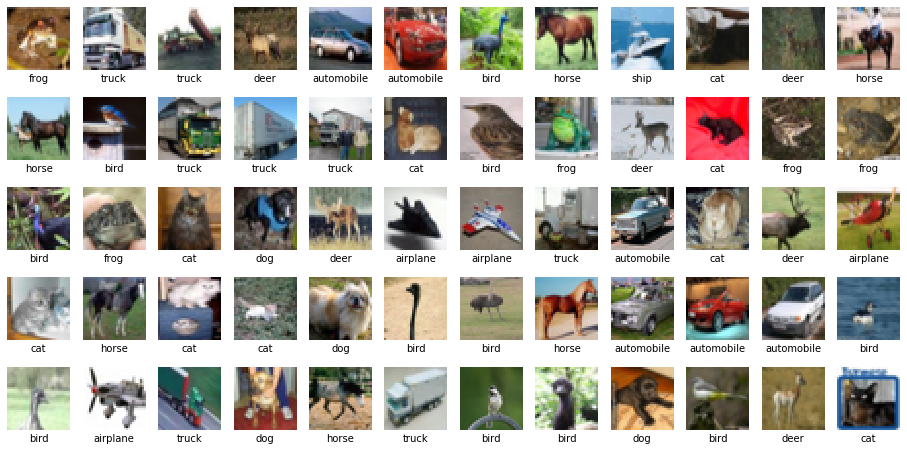

In [25]:
classNames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(5, 12, figsize=(16,8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(xTrain[i], cmap=plt.cm.binary)
    ax.set_xlabel(classNames[yTrain[i][0]])
plt.setp(axes, xticks=[], yticks=[], frame_on=False);

## The model

We will use the model of the Tensorflow tutorial [[1](#References)] adding some regularization through a dropout layer. See the MNIST model notebook for more details on regularization and hyper-parameter tuning ([HTML](CnnVsDense-Part1.ipynb) / [Jupyter](CnnVsDense-Part1.ipynb).

The model below is very similar to the LeNet5 model described in this later notebook. There are however 3 convolution layers instead of 2 in LeNet5, these layers are wider (6 and 16 units in LeNet5), and 2 dense (fully connected) compared to 3.

In [34]:
metricNames = ['Categorical cross-entropy', 'Accuracy']
metricNamesRaw = ['loss', 'accuracy']

In [35]:
model0 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), name="conv_0"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', name="conv_1"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', name="conv_2"),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', name="dense_0"),
    layers.Dense(10, activation='softmax', name="dense_1")
])

model0.compile(optimizer='adam',
          loss=losses.sparse_categorical_crossentropy,
          metrics=['accuracy'])
    
model0.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

Training and validation are performed on the trainin set with a split ratio of 90-10. The test set is reserved for later evaluation of the optimized model.

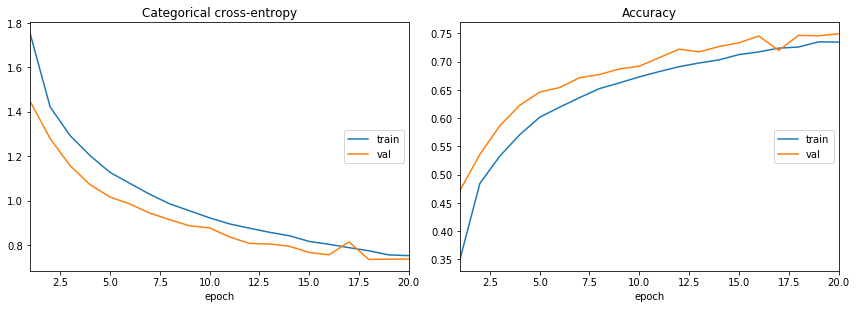

In [36]:
nEpochs = 20
batchSize = 128

tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,4), columns=2, iter_num=nEpochs, wait_num=2)

history0 = model0.fit(xTrain, yTrain,
            epochs=nEpochs, batch_size=batchSize, 
            validation_split=0.1, 
            verbose=0,
            callbacks=[tvPlot]);

The validation loss and accuracy are better than the ones of the training, this is expected given the dropout layer.

Compared to the network described in the Tensorflow tutorial, the validation accuracy is not stalling. It probably means that the network is overfitting, regularization is good.

## Evaluation of the model

In [37]:
loss, acc = model0.evaluate(xTest, yTest, verbose=0)
print("Model test accuracy = %.2f %%" % (acc*100))

Model test accuracy = 73.78 %


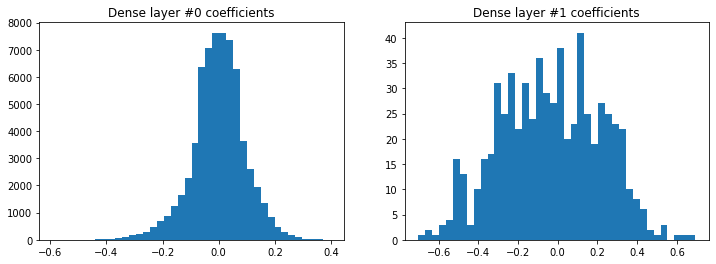

In [43]:
weights0 = model0.get_weights()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, layerIndex, weightIndex in zip(axes, [0, 1], [6, 8]):
    ax.hist(weights0[weightIndex].ravel(), density=False, bins=40)
    ax.set_title("Dense layer #%d coefficients" % layerIndex)

The distributions on the weights of the Dense layers is well balanced and there are not so many weights close to 0.

## Save model

In [44]:
model0.save('models/CIFA-10_CNN5.h5')

## References

1.Tensorflow tutoria for CNN - https://www.tensorflow.org/tutorials/images/cnn